# Création d'un Agent avec LangGraph

Dans ce notebook, nous allons créer un agent intelligent capable d'interagir avec un modèle de langage, d'utiliser des outils externes, et de traiter des questions de manière automatique. Vous utiliserez LangGraph pour construire un agent doté de logique conditionnelle et capable d'exécuter plusieurs actions. Nous allons vous guider pas à pas à travers chaque étape pour vous assurer de bien comprendre les concepts abordés.

**Objectif :** Créer un agent autonome avec LangGraph.

#### 0. Préparation

Dans ce notebook, nous utiliserons l'API Groq, vous devez vous inscrire sur [**Groq**](https://console.groq.com/login/) et [**récupérer une clé d'API**](https://console.groq.com/keys).   

*Optionnel : Pour surveiller les appels faits aux modèles LLMs, nous vous conseillons aussi d'utiliser LangSmith. Vous devrez [**générer une clé d'API LangSmith**](https://smith.langchain.com/settings) puis activer le traçage.

Nous aurons aussi besoin d'une clé d'API pour le Tavily, vous devrez [**vous inscrire et récupérer une clé d'API**](https://app.tavily.com/)

Une fois les clés obtenues, ajoutez-les à vos variables d'environnement :


In [1]:
import os

# Remplacez "<votre_cle_openai>" par votre clé API OpenAI
os.environ["GROQ_API_KEY"] = "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"

# Remplacez "<votre_cle_langsmith>" par votre clé API LangSmith
#os.environ['LANGCHAIN_TRACING_V2'] = "true"
#os.environ['LANGCHAIN_API_KEY'] = "<votre_cle_langsmith>"

# Remplacez "<votre_cle_tavily>" par votre clé API OpenAI
os.environ["TAVILY_API_KEY"] = "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"

### 1. Chargement de l'outil Tavily

Nous allons charger l'outil **TavilySearchResults**, qui nous permet d'effectuer des recherches sur internet. Cet outil est précieux pour enrichir notre agent avec des informations récentes.
Nous importons l'outil TavilySearchResults et nous l'initialisons avec un maximum de 4 résultats par recherche. Cela nous permet de limiter les réponses et d'éviter une surcharge d'informations :

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


### 2. Définition de l'état de l'agent

Dans cette section, nous définissons la structure de l'état de l'agent. Cet état est utilisé pour suivre les messages échangés entre l'utilisateur, le modèle, et les outils.
Nous utilisons ici **TypedDict** pour définir une classe qui va conserver les messages échangés au sein de l'agent. Le champ **messages** permet de stocker chaque interaction pour que l'agent puisse se souvenir de la conversation et agir en conséquence :

In [3]:
import operator
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

### 3. Création de l'agent

Passons maintenant à la création de l'agent. Cette classe **Agent** définit le comportement de notre agent, y compris la façon dont il utilise les outils disponibles et interagit avec le modèle de langage.

La classe **Agent** permet de définir la logique de notre agent. 
- Elle utilise un **StateGraph** pour contrôler les différentes étapes, à savoir appeler le modèle OpenAI et utiliser des outils pour répondre aux demandes.
- Les fonctions **call_openai** et **take_action** définissent la façon dont l'agent communique avec le modèle et prend des actions respectives.
- Les outils utilisés sont stockés dans **self.tools** et sont liés au modèle via **self.model**.

In [4]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


class Agent:

    def __init__(self, model, tools, system=""):
        # Initialise l'agent avec un modèle de langage, des outils, et une configuration système.
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_llm)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        # Vérifie si une action est nécessaire après la dernière réponse du modèle.
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_llm(self, state: AgentState):
        # Appelle le modèle de langage pour obtenir une réponse en fonction des messages précédents.
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        # Exécute les actions spécifiées par le modèle de langage, en utilisant les outils disponibles.
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

### 4. Instanciation de l'agent

Maintenant, nous allons créer une instance de notre agent et lui fournir un prompt système. Ce prompt va définir le rôle de notre agent en tant qu'assistant de recherche intelligent.
Avec cette configuration, l'agent va se comporter comme un assistant de recherche. Le modèle utilisé est GPT-3.5-Turbo pour minimiser les coûts d'inférence :

In [5]:
#1
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

#2 LLM
model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.0,
    max_retries=2,
    # other params...
)

#3
agent = Agent(model, [tool], system=prompt)

### 5. Visualisation du graph de l'agent

Visualisons le graphe établi par notre agent pour comprendre les différentes étapes de traitement.

Cette image montre le flux de travail de l'agent, où chaque noeud représente une étape importante dans l'exécution de l'agent, depuis l'appel au modèle jusqu'à la prise d'action :


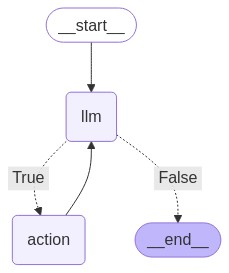

In [6]:

from IPython.display import Image

Image(agent.graph.get_graph().draw_mermaid_png())

### 6. Utilisation simple

Essayons d'utiliser l'agent pour poser une question simple concernant la météo. Et regardons le résultat complet :

In [9]:
messages = [HumanMessage(content="What is the weather in Paris?")]
result = agent.graph.invoke({"messages": messages})

print('\n Result :')
print(result)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Paris weather today'}, 'id': 'call_py0w', 'type': 'tool_call'}
Back to the model!

 Result :
{'messages': [HumanMessage(content='What is the weather in Paris?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_py0w', 'function': {'arguments': '{"query": "Paris weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 350, 'total_tokens': 370, 'completion_time': 0.026666667, 'prompt_time': 0.064707895, 'queue_time': 0.296926722, 'total_time': 0.091374562}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_bc861211a5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4b3a2fb4-36d7-460e-bf9c-3f1c7cc222f5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Paris weather today'}, 'id': 'call_py0w', 'type': 'tool_call'}]

Nous pouvons maintenant visualiser la réponse générée par notre agent :

In [10]:
print(result['messages'][-1].content)

The current weather in Paris is sunny with a temperature of 13.1°C (55.6°F). The forecast for the next few days predicts temperatures to be around 17°C, close to the historical average. There is a chance of rain on some days, but it is not expected to be heavy. It is recommended to bring warm clothes as the temperatures can be quite cold, especially in the mornings and evenings.


### 6. Utilisation avec plusieurs interactions

Pour explorer un peu plus les capacités de l'agent, essayons une question plus complexe concernant la météo dans deux villes différentes.   
Encore une fois, nous demandons à l'agent de récupérer des informations sur la météo mais cette fois-ci dans deux endroits différents. Cela permet de tester la capacité de l'agent à traiter plusieurs réponses simultanément.

In [12]:
messages = [HumanMessage(content="What is the weather in SF ?")]
result = agent.graph.invoke({"messages": messages})

print('\n Result :')
print(result['messages'][-1].content)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'SF weather today'}, 'id': 'call_tg1k', 'type': 'tool_call'}
Back to the model!

 Result :
The current weather in SF is cloudy with overcast skies and a temperature of 66°F (19.2°C) during the day and 54°F (12.2°C) at night.


### 7. Utilisation avec une question composée

Dans cet exemple, nous allons poser une question composée où l'agent doit effectuer des recherches successives pour fournir la réponse.  
Nous utilisons un modèle plus avancé (GPT-4) pour obtenir des réponses précises sur plusieurs sujets liés entre eux. Cela montre comment l'agent peut naviguer à travers des requêtes complexes :

In [13]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatGroq(model="deepseek-r1-distill-llama-70b")
agent = Agent(model, [tool], system=prompt)

result = agent.graph.invoke({"messages": messages})


print('\n Result :')
print(result['messages'][-1].content)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_g9bb', 'type': 'tool_call'}
Back to the model!

 Result :
The Kansas City Chiefs won Super Bowl LVIII (58) in 2024, defeating the San Francisco 49ers with a score of 25-22 in overtime. The winning team, the Kansas City Chiefs, is headquartered in Missouri. To provide the GDP of Missouri, I need to perform another search.


### Conclusion

Vous avez maintenant une meilleure compréhension de la manière de créer et de configurer un agent avec **LangGraph**. Vous pouvez explorer davantage en ajoutant de nouveaux outils ou en modifiant le comportement de l'agent pour l'adapter à différents scénarios. Essayez de poser des questions variées et d'observer comment l'agent réagit !